### Energy ###

Energy J[i, j] between two nearest-neighbour acids that are not connected in the chain
<ul>
    <li>Combined contributions of VDW, covalent bonds, and water effects</li>
    <li>Depends on acid types of i and j</li>
    <li>Energy between non-nearest-neighbours taken to be 0</li>
    <li>Total energy of the protein is the sum over all non-covalently-bonded nearest neighbours (NBNN)</li>
    <li>Remember not to simply double-count pair energies</li>
    <li>Which acids are NBNN depends on the tertiary structure of the protein (Energy is a function of structure)</li>
</ul>


### Initialization ###

Before the actual simulation:
<ol>
    <li>Choose a (permanent) primary structure for the protein:
        <ol>
            <li>Determine length of protein chain (N)</li>
            <li>Decide (randomly) types of the N amino acids making up the chain (each link is an integer between 1 and 20)</li>
            <li>These integers will be stored in an array of length N, called A.</li>
        </ol>
    </li>
    <li>Specify interaction energies J<sub>i,j</sub> between the different types of acids:
        <ul>
            <li>20x20 matrix (20 different types) J</li>
            <li>Index J at i,j to get the interaction energy between acid types i and j</li>
            <li>We will assume that J<sub>i,j</sub> vary randomly withing some specified range (-4 to -2?)</li>
            <li><strong>Note: This can be changed. Setting J<sub>i,j</sub> to +-1 could be interesting</strong></li>
        </ul>
    </li>
    <li>Choose an initial tertiary structure for the protein:
        <ul>
            <li>Can be a completely straight chain</li>
            <li>Self-avoiding walk?</li>
        </ul>
    </li>
    <li>Put the protein on a sufficiently large lattice
</ol>

### Simulation ###

In one sweep of the protein, the following is done:

Note: Think about pre-generating random numbers outside of loops.
<ol>
    <li>Randomly select an acid, a, from A (by choosing a random number between 0 and N-1)</li>
    <li>This acid is said to have coordinates (x<sub>0</sub>, y<sub>0</sub>)</li>
    <li>Randomly select one of a's nearest neighbour positions (x<sub>n</sub>, y<sub>n</sub>)
        (<strong>Note: The text is unclear as to what constitutes a nearest neighbour. It says that each position has 4 
        nearest neighbours, but then says acids can transfer to a position diagonal to them - implying that each acid has 
        8 nearest neighbours, at least as far as transitions are concerned (for energy calculations, it seems to be the 
        classic 4 - see Figure 12.3)
        </strong>
    </li>
    <li>See if a could move to (x<sub>n</sub>, y<sub>n</sub>) without breaking a covalent bond</li>
    <li>If so, calculate the energy of the acid with its current neighbours, and that with its potential new neighbours</li>
    <li>If the change in energy is <strong>negative</strong>, move the acid</li>
    <li>Otherwise, move it probabilistically (if random num from 0-1 less than boltzmann factor exp(-dE/kT))</li>
    <li>Accumulate running sums for averages</li>
</ol>

This can be one MCS, or you can do this N times for one MCS.

After you do all sweeps, divide running sums by number of sweeps to get averages for the particular temperature at which 
the sweeps were performed.

Can investigate starting unfolded at a high temperature and seeing how Energy and Chain Length vary with temperature.

Can also investigate how an initially unfolded chain behaves at low temperature (Levinthal's paradox):
<ul>
    <li>Run simulation at low temperature on same chain multiple times</li>
    <li>Find time series of energy for each run (E vs Current MC step)</li>
    <li>Find that runs have different final energies (tertiary structures)</li>
    <li>In each case, protein was in "metastable" state, was not able to locate global minimum</li>
    <li>Actual protein is able to find global minimum from so many possible structures in no time!!!!!!!</li>
</ul>

How might we solve this paradox, and get the protein into the lowest energy state?

Annealing:
<ul>
    <li>Start the simulation at a very high temperature, allowing the protein to explore all of the configurations</li>
    <li>Slowly lower the temperature, so the protein will still fluctuate, but will spend increasing amounts of time 
    in the lowest-energy state</li>
    <li>When the final temperature is reached, hopefully the protein managed to sample a bunch of different states, and has 
    landed in the most stable one.</li>
</ul>

### Notes ###

<ul>
    <li>Measured quantities will likely be total energy and end-to-end length, where length is calculated as the pythagorean 
    difference between the coordinates of the acids on each end of the chain</li>
    <li>Should notice a fairly abrupt transition in these quantities around T = 2. Transition should get more abrupt with 
    larger chain (i.e. N = 100)</li>

### Take-away ###
<ul>
    <li>Our model does show a transition to a folded structure at low T</li>
    <li>We are not able to avoid getting trapped in meta-stable states, but annealing helps</li>
    <li>Annealing is less effective on longer (therefore more realistic) protein chains, since these chains have more possible 
    states, so can explore a smaller fraction of them in a given amount of time</li>
    <li>So how does nature seem to avoid Levinthal's paradox, and so quickly?
        <ul>
            <li>Maybe it doesn't</li>
            <li>Nature only uses a small portion of the possible primary structures</li>
            <li>It is possible that the ones used have energy surfaces that allow them to efficiently get to their unique 
            tertiary structure</li>
        </ul>
    </li>
</ul>

### Coding ###

<ul>
    <li>Collection of acids, A, will be numpy 1d-array of numpy 1d-arrays [type, x, y]</li>
    <li>Types will be random, created in the initialization period using numpy.random.randint()
    <li>Lattice will be numpy 2d-array holding the chain</li>
    
</ul>

## Initialization ##

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from numba import jit
import math
from scipy import optimize

In [2]:
N = 30

# Interaction energies between different types of acids
# Interaction energy between type i and type j is J[i, j]
J = np.random.uniform(-4, -2, size=(20, 20))
J = np.hstack((np.zeros((J.shape[0],1)),J)) # Type 0 doesn't exist, has an interaction energy
J = np.vstack((np.zeros((1,J.shape[1])),J)) # of 0 with every type
J = (J + J.T)/2



# The type of each acid in the chain
types = np.random.randint(1, 21, size=N, dtype=int)


# Create x and y coordinates such that the chain will be horizontal, and centered in the 2N x 2N lattice
x_start = int(2*N)
x_end = int(3*N)
y_start = int(2.5*N)
pos_xs = np.arange(x_start, x_end, dtype=int)
pos_ys = np.empty(N, dtype=int); pos_ys.fill(y_start)


# Zip type, x_pos, and y_pos to create array defining each acid (this is the protein)



#left-down, left-up, right-up, right-down
move_neighs = np.array([(-1,1), (-1,-1), (1,-1), (1,1)], dtype=int)

In [3]:
@jit
def initialize_lattice():

    A = np.empty(shape=(N,3), dtype=int)
    for i in range(A.shape[0]):
        A[i] = np.array([types[i], pos_xs[i], pos_ys[i]])
    
    lattice = np.zeros(shape=(5*N,5*N), dtype=int)
    
    # Put protein on lattice
    lattice[y_start, x_start:x_end] = types
    
    return lattice, A

## Helper Methods ##

In [4]:
@jit
def get_neighbours(lattice, x, y):
    left = (x-1, y) if not x == 0 else None
    bottom = (x, y+1) if not y == lattice.shape[1]-1 else None
    right = (x+1, y) if not x == lattice.shape[0]-1 else None
    top = (x, y-1) if not y == 0 else None
        
    return [left, bottom, right, top]

In [5]:
@jit
def energy(lattice, a_type, x, y, partners):
    
    #global lattice
    
    neighbours = get_neighbours(lattice, x, y)
    
    #print("\nEnergy For " + str(x) + ", " + str(y))
        
    E = 0
    for neigh in neighbours:
        
        if neigh not in partners:
            
            #print(str(neigh) + " " + str(lattice[neigh[1], neigh[0]]))
            
            str(lattice[neigh[1], neigh[0]])
            
            neigh_type = lattice[neigh[1], neigh[0]] # SLOW
            E += J[a_type, neigh_type]
      
    #print("E: " + str(E))
    return E

In [6]:
@jit
def re_center(lattice, A):
    
    offset_x = x_start - A[0,1]
    offset_y = y_start - A[0,2]
    
    for row in A:
        
        lattice[row[2], row[1]] = 0
        
        row[1:] = [row[1] + offset_x, row[2] + offset_y]
        
        lattice[row[2], row[1]] = row[0]
    
    return lattice, A

## Monte Carlo Sweep ##

In [7]:
# Selects one acid, determines the change in energy from moving that acid, then either moves it or doesn't
@jit
def sweep(lattice, A, E_chain, acid_pos, neigh_type, curr_prob, T): 
    
    
    acid = A[acid_pos]
    acid_x = acid[1]
    acid_y = acid[2]
    
    
    # Determine the acids the currently examined acid is bonded to 
    first_partner = tuple(A[acid_pos-1, 1:]) if not acid_pos == 0 else None
    second_partner = tuple(A[acid_pos+1, 1:]) if not acid_pos == len(A)-1 else None
    partners = (first_partner, second_partner)
        
    
    # Randomly select a nearest neighbour to move to    
    neigh_offset = move_neighs[neigh_type]
    
    neigh_pos = (acid_x+neigh_offset[0], acid_y+neigh_offset[1]) # creating a tuple is faster than assigning a list
    
    
    # Determine if acid can move to selected position without breaking bonds  
    can_move = True
    
    if lattice[neigh_pos[1], neigh_pos[0]] != 0:
        can_move = False
        
    else:
        for partner in partners:
            if partner is None:
                continue
            elif not (abs(partner[0] - neigh_pos[0]) + abs(partner[1] - neigh_pos[1]) == 1):
                can_move = False
    
    #print(can_move)
    
    
    if can_move:
        
        
        # Show the protein on the lattice
        #plt.imshow(lattice)
        #plt.show()
        
        E_i = energy(lattice, acid[0], acid_x, acid_y, partners)
        E_f = energy(lattice, acid[0], neigh_pos[0], neigh_pos[1], partners)
        delta_E = E_f-E_i    

        
        if delta_E < 0 or curr_prob < math.exp(-delta_E/T):
            
            #print("\nMoving from (" + str(acid_x) + ", " + str(acid_y) + ") to (" + str(neigh_pos[0]) + ", " + 
                  #str(neigh_pos[1]) + ")")
            
            lattice[acid_y, acid_x] = 0
                        
            lattice[neigh_pos[1], neigh_pos[0]] = acid[0]
            
            A[acid_pos] = [acid[0], neigh_pos[0], neigh_pos[1]]
            
            
            #print("\nNew neighbours: " + str(get_neighbours(neigh_pos[0], neigh_pos[1])))
                        
            
            E_chain += delta_E
            
            #print("changed A at " + str(acid_pos))
            #print(A)

    #l_chain = (A[0, 1] - A[A.shape[0]-1, 1])**2 + (A[0, 2] - A[A.shape[0]-1, 2])**2
    #l_chain = math.sqrt(l_chain)
        
    return lattice, A, E_chain#, l_chain

## Thermal Averages ##

As expected, when starting at a high temperature (T = 10) and gradually decreasing, the average energy of the chain 
decreased. This makes sense, since the chain is more free to explore a greated number of states at high temperature, 
since the probability of making a move that increases the energy of the chain is proportional to temperature. As the 
temperature decreases, the chain is more likely to get stuck in a relatively low energy state.

Done 10.0


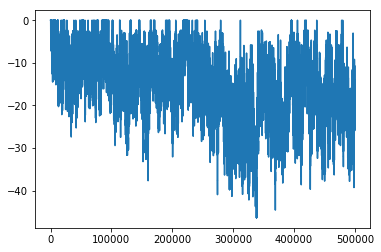

Done 9.5


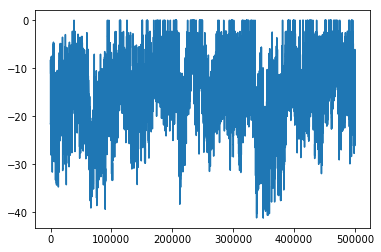

Done 9.0


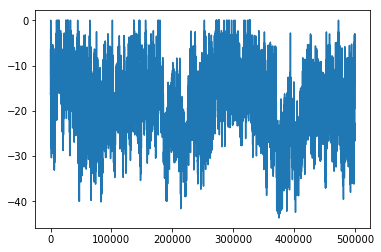

Done 8.5


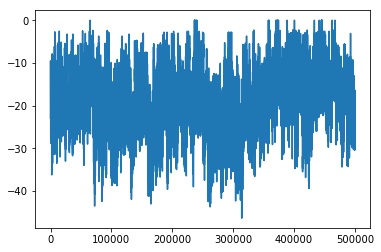

Done 8.0


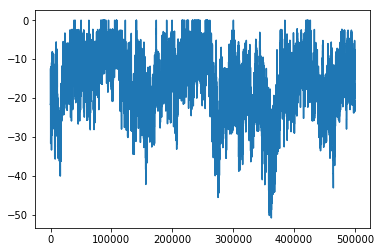

Done 7.5


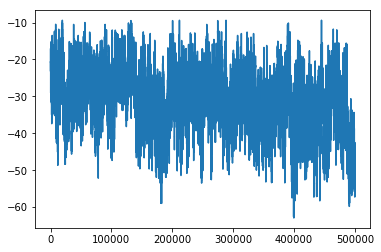

Done 7.0


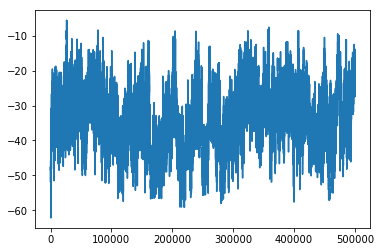

Done 6.5


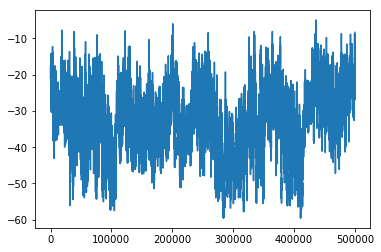

Done 6.0


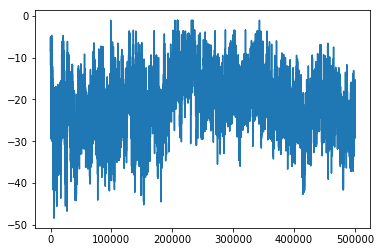

Done 5.5


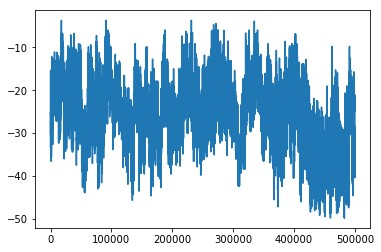

Done 5.0


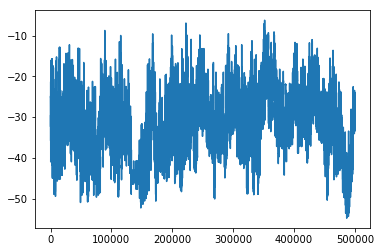

Done 4.5


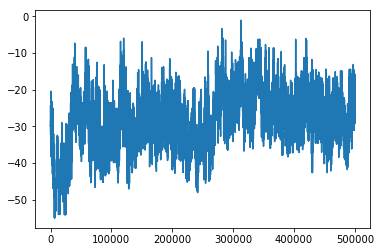

Done 4.0


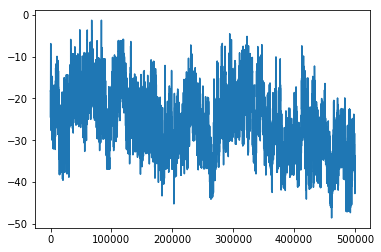

Done 3.5


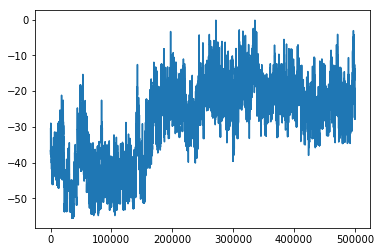

Done 3.0


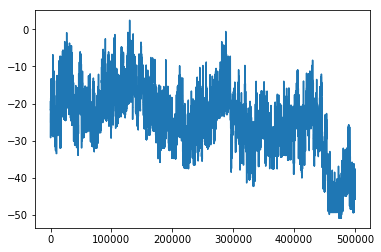

Done 2.5


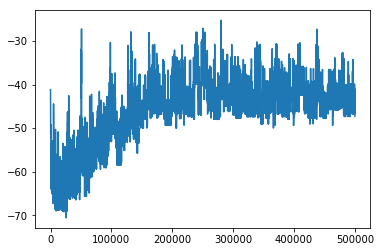

Done 2.0


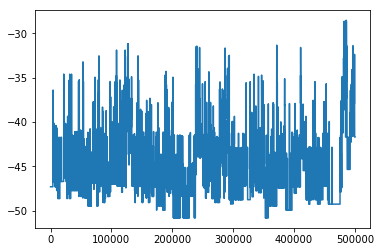

Done 1.5


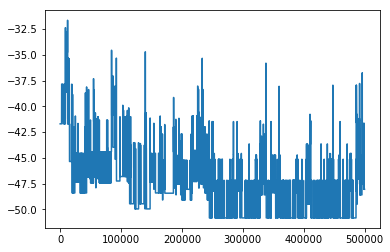

Done 1.0


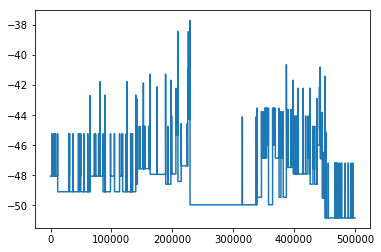

Done 0.5


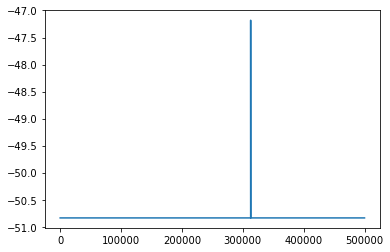

In [8]:
MCS = 500000

T = np.arange(10, 0, -0.5)

E_averages = np.zeros(len(T))
#l_averages = np.zeros(len(T))

lattice, A = initialize_lattice()
E_chain = 0


for j in range(len(T)):
    
    E = np.zeros(MCS)
    E_average = 0
    #l_average = 0



    #plt.imshow(lattice)
    #plt.show()


    # Pre-select random acid and neighbour picks for better performance
    acid_picks = np.random.randint(0, A.shape[0], size=MCS) # 1 acid picked from A each MCS
    curr_acid_pick = 0

    neigh_picks = np.random.randint(0, 4, size=MCS) # 1 acid picked from A each MCS
    curr_neigh_pick = 0

    prob_picks = np.random.uniform(0, 1, size=MCS)
    curr_prob_pick = 0


    for i in range(MCS):
        E[i] = E_chain
        lattice, A, E_chain = sweep(lattice, A, E_chain, acid_picks[curr_acid_pick], 
                                    neigh_picks[curr_neigh_pick], prob_picks[curr_prob_pick], T[j])

        if (i>0.1*MCS):
            E_average += E_chain
            #l_average += l_chain

        curr_acid_pick += 1
        curr_neigh_pick += 1
        curr_prob_pick += 1


    print("Done " + str(T[j]))
    
    plt.plot(np.arange(MCS), E)
    plt.show()


    E_average /= (0.9*MCS-1)
    E_averages[j] = E_average
    
    #l_average /= (0.9*MCS-1)
    #l_averages[j] = l_average
    
    lattice, A = re_center(lattice, A)

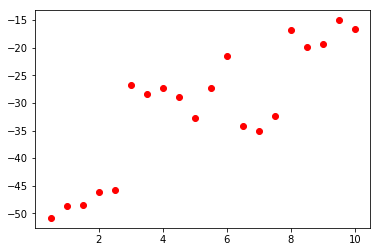

30


In [9]:
plt.plot(T, E_averages, 'ro')
#plt.ylim(ymax=-10)
#plt.ylim(ymin=-50)
plt.show()

print(A.shape[0])

#plt.plot(T, l_averages, 'ro')
#plt.ylim(ymax=6)
#plt.ylim(ymin=2.5)
#plt.show()

In [ ]:
'''
out = open('100.dat', 'w')
for i in range(len(T)):
    out.write(str(T[i]) + " " + str(E_averages[i]) + "\n")
    
out.close()
'''

## Two simulations at Low Temperature ##

Taking the same chain through the simulation twice, at the same temperature each time, produced different results. 
The chain ended up at a different energy in each simulation, corresponding to the protein being in a different final 
tertiary structure. This is a result of "metastable" states, or local minima in the energy. While looking for the global 
minimum, the chain gets stuck in a metastable state, which can be pictured as a well. At low temperature, the chain is unlikely to escape the well, since it is unlikely to make moves that increase the energy. As we know, real proteins are able to get to the same final structure almost instantly each time they are unfolded. This means that our model is not behaving like a real protein.

In [10]:
T = 1

MCS = 500000

lowT_Es = np.zeros((2, MCS))


for j in range(2):

    
    lattice, A = initialize_lattice()
    E_chain = 0
    E = np.zeros(MCS)


    # Pre-select random acid and neighbour picks for better performance
    acid_picks = np.random.randint(0, A.shape[0], size=MCS) # 1 acid picked from A each MCS
    curr_acid_pick = 0

    neigh_picks = np.random.randint(0, 4, size=MCS) # 1 acid picked from A each MCS
    curr_neigh_pick = 0

    prob_picks = np.random.uniform(0, 1, size=MCS)
    curr_prob_pick = 0


    for i in range(MCS):
        E[i] = E_chain
        lattice, A, E_chain = sweep(lattice, A, E_chain, acid_picks[curr_acid_pick],
                                    neigh_picks[curr_neigh_pick], prob_picks[curr_prob_pick], T)


        curr_acid_pick += 1
        curr_neigh_pick += 1
        curr_prob_pick += 1


    lowT_Es[j] = E

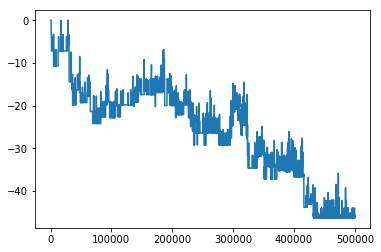

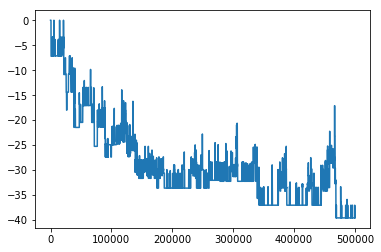

In [11]:
plt.plot(np.arange(MCS), lowT_Es[0])
plt.show()

plt.plot(np.arange(MCS), lowT_Es[1])
plt.show()

In [ ]:
#Done with N=30

'''
out1 = open('lowT1.dat', 'w')
out2 = open('lowT2.dat', 'w')

for i in range(500000):
    out1.write(str(i) + " " + str(lowT_Es[0,i]) + "\n")
    out2.write(str(i) + " " + str(lowT_Es[1,i]) + "\n")
    
out1.close()
out2.close()
'''

## Annealing ##

To try to get our model to behave more like a real protein, we use a process called Annealing. 
This means that we start the simulation at a temperature that is high enough so that energy fluctuations are large, and the 
chain can escape energy wells. The temperature is slowly lowered, so that it spends an increasing amount of time 
in the states with the lowest energies. When the final temperature is reached, the protein will be stuck in some final state, 
which is hopefully the lowest energy state.

In [12]:
T = 5

MCS = 2000000

lattice, A = initialize_lattice()
E_chain = 0
E = np.zeros(MCS)


# Pre-select random acid and neighbour picks for better performance
acid_picks = np.random.randint(0, A.shape[0], size=MCS) # 1 acid picked from A each MCS
curr_acid_pick = 0

neigh_picks = np.random.randint(0, 4, size=MCS) # 1 acid picked from A each MCS
curr_neigh_pick = 0

prob_picks = np.random.uniform(0, 1, size=MCS)
curr_prob_pick = 0


for i in range(MCS):
    E[i] = E_chain
    lattice, A, E_chain = sweep(lattice, A, E_chain, acid_picks[curr_acid_pick],
                                neigh_picks[curr_neigh_pick], prob_picks[curr_prob_pick], T)


    curr_acid_pick += 1
    curr_neigh_pick += 1
    curr_prob_pick += 1
    
    if i%500000 == 0:
        T -= 1
        print(T)




4
3
2
1


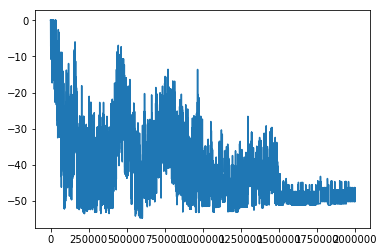

In [13]:
plt.plot(np.arange(MCS), E)
plt.show()

In [ ]:
'''
anneal_out = open('anneal.dat', 'w')
for i in range(2000000):
    anneal_out.write(str(i) + " " + str(E[i]) + "\n")
    
anneal_out.close()
'''